In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

## Part 1: Rebalancing Problem
Here the objective function does not include transaction cost consideration because it is just a static rebalancing.

In [2]:
# LOAD CLEANED DATA

df = pd.read_csv("data/preprocessed/industry_returns_preprocessed.csv", parse_dates=['Date'])
df = df.sort_values('Date')

# Identify industry columns
industry_cols = [c for c in df.columns if c not in ['Date', 'Mkt', 'RF']]
print("Industries:", industry_cols)

n = len(industry_cols)

Industries: ['Food', 'Clths', 'Durbl', 'Chems', 'Cnsum', 'Cnstr', 'Steel', 'FabPr', 'Machn', 'Cars', 'Trans', 'Utils', 'Rtail', 'Finan', 'Other']


In [3]:
#COMPUTE COVARIANCE MATRICES

# Industry return matrix
R = df[industry_cols]

# Market return
Rm = df["Mkt"]

# Covariance matrix of industries
Sigma = R.cov().values    # n x n

# Covariance vector between each industry and market return
cov_with_mkt = R.covwith(Rm) if hasattr(R, 'covwith') else R.apply(lambda x: np.cov(x, Rm)[0,1])
cov_with_mkt = cov_with_mkt.values     # length n

In [4]:
# BUILD GUROBI MODEL

m = gp.Model("Index_Replication_Part1")

# Decision variables w_i ≥ 0
w = m.addVars(n, lb=0, ub=1, name="w")

Restricted license - for non-production use only - expires 2027-11-29


In [5]:
# CONSTRAINTS

# Full investment
m.addConstr(gp.quicksum(w[i] for i in range(n)) == 1, name="full")

# Max 20% each
for i in range(n):
    m.addConstr(w[i] <= 0.20, name=f"max20_{industry_cols[i]}")

# Industry portfolio weight constraints
for i, col in enumerate(industry_cols):
    if col == "Trans":
        m.addConstr(w[i] <= 0.01, name=f"cap_trans_1pct")
    if col == "Utils":
        m.addConstr(w[i] <= 0.01, name=f"cap_utils_1pct")
    if col == "Machn":     # Machinery & Business Equipment
        m.addConstr(w[i] <= 0.08, name=f"cap_machn_8pct")

Minimizing
$
\mathbb{E}\!\left[(w^\top r_i - r_{\text{mkt}})^2\right]
$
is the natural and industry-standard objective for index replication, because it directly
penalizes deviations between the replicating portfolio and the market index. The squared
formulation ensures a convex quadratic program, incorporates both variance and covariance
structure, and heavily penalizes large tracking errors that materially degrade replication
quality. Therefore, this objective yields a diversified, stable portfolio whose return
behavior matches the market as closely as possible.


In [6]:
# 5. OBJECTIVE: minimize E[(w'r_i – r_mkt)^2]
# Quadratic term: w' Σ w
quad_expr = gp.QuadExpr()
for i in range(n):
    for j in range(n):
        quad_expr += w[i] * w[j] * Sigma[i, j]

# Linear term: –2 * w' Cov(r_i, r_mkt)
lin_expr = gp.LinExpr()
for i in range(n):
    lin_expr += -2 * cov_with_mkt[i] * w[i]

# Objective (constant market variance dropped)
m.setObjective(quad_expr + lin_expr, GRB.MINIMIZE)

In [7]:
m.optimize()

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 19 rows, 15 columns and 33 nonzeros (Min)
Model fingerprint: 0xc010a633
Model has 15 linear objective coefficients
Model has 120 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+01, 8e+01]
  QObjective range [5e+01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 1e+00]
Presolve removed 18 rows and 0 columns
Presolve time: 0.01s
Presolved: 1 rows, 15 columns, 15 nonzeros
Presolved model has 120 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 14
 AA' NZ     : 1.050e+02
 Factor NZ  : 1.200e+02
 Factor Ops : 1.240e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     


Optimal Weights:
Food: 0.0928
Clths: 0.0057
Durbl: 0.0029
Chems: 0.0610
Cnsum: 0.1317
Cnstr: 0.0575
Steel: 0.0750
FabPr: 0.0361
Machn: 0.0800
Cars: 0.0485
Trans: 0.0100
Utils: 0.0100
Rtail: 0.0604
Finan: 0.1285
Other: 0.2000


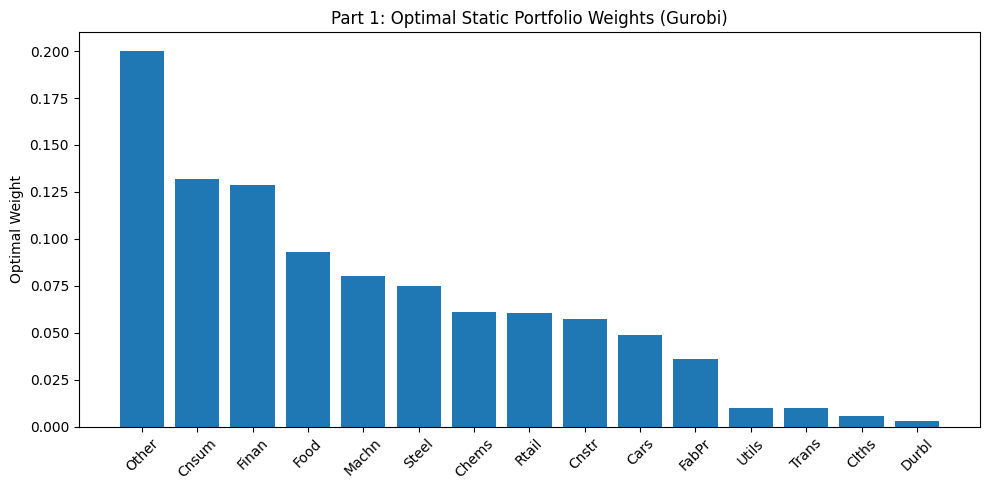

In [8]:
# DISPLAY RESULTS

if m.status == GRB.OPTIMAL:
    print("\nOptimal Weights:")
    results = []
    for i, col in enumerate(industry_cols):
        w_val = w[i].X
        print(f"{col}: {w_val:.4f}")
        results.append((col, w_val))

    results_df = pd.DataFrame(results, columns=["Industry", "Weight"]).sort_values("Weight", ascending=False)

    # Bar plot
    plt.figure(figsize=(10, 5))
    plt.bar(results_df["Industry"], results_df["Weight"])
    plt.xticks(rotation=45)
    plt.ylabel("Optimal Weight")
    plt.title("Part 1: Optimal Static Portfolio Weights (Gurobi)")
    plt.tight_layout()
    plt.show()

else:
    print("Model did not solve. Status:", m.status)

## Part 3: 
### Objective Function

The portfolio weights $w_t$ at each rebalancing time $t$ are obtained by solving an 
optimization problem with two components: 

- the **primary objective** is to minimize expected squared tracking error,  
- the **secondary objective** is to penalize turnover (transaction costs).

The overall objective is:

$$
\min_{w_t}
\left[
\mathbb{E}_t \big( w_t^\top r_{i,t+1} - r_{\text{mkt},t+1} \big)^2
+
\kappa \sum_{i=1}^{N} \lvert w_{i,t} - w_{i,t-1} \rvert
\right].
$$

Using the identity

$$
\mathbb{E}_t\left[(w^\top r_i - r_{\text{mkt}})^2\right]
=
w^\top \Sigma_t w
- 2 w^\top \mathrm{Cov}_t(r_i, r_{\text{mkt}})
+ \mathrm{Var}_t(r_{\text{mkt}}),
$$

and noting that $\mathrm{Var}_t(r_{\text{mkt}})$ is constant with respect to $w$,  
the optimization problem becomes:

$$
\min_{w_t}
\left[
w_t^\top \Sigma_t w_t
-
2\, w_t^\top \mathrm{Cov}_t(r_i, r_{\text{mkt}})
+
\kappa \sum_{i=1}^N \lvert w_{i,t} - w_{i,t-1} \rvert
\right].
$$

To implement the absolute value constraint in Gurobi, we introduce auxiliary variables 
$d_{i,t} \ge 0$ satisfying:

$$
d_{i,t} \ge w_{i,t} - w_{i,t-1}, \qquad
d_{i,t} \ge -(w_{i,t} - w_{i,t-1}),
$$

so that $d_{i,t} = \lvert w_{i,t} - w_{i,t-1} \rvert$ at the optimum.

Thus the final optimization problem is:

$$
\min_{w_t,\, d_t}
\left[
w_t^\top \Sigma_t w_t
-
2\, w_t^\top \mathrm{Cov}_t(r_i, r_{\text{mkt}})
+
\kappa \sum_{i=1}^N d_{i,t}
\right].
$$


In [9]:
def solve_optimal_weights(Sigma, cov_with_mkt, industry_cols, prev_w, kappa=0.001):
    n = len(industry_cols)

    m = gp.Model("Index_Replication_Window")
    m.setParam("OutputFlag", 0)

    # Decision variables
    w = m.addVars(n, lb=0, ub=1, name="w")

    # Auxiliary variables for |w[i] - prev_w[i]|
    d = m.addVars(n, lb=0, name="d")

    # Full investment
    m.addConstr(gp.quicksum(w[i] for i in range(n)) == 1)

    # Caps
    for i in range(n):
        m.addConstr(w[i] <= 0.20)
    for i, col in enumerate(industry_cols):
        if col == "Trans":
            m.addConstr(w[i] <= 0.01)
        if col == "Utils":
            m.addConstr(w[i] <= 0.01)
        if col == "Machn":
            m.addConstr(w[i] <= 0.08)

    # ---------- Linearize absolute value ----------
    for i in range(n):
        # d_i ≥ w_i – prev_w_i
        m.addConstr(d[i] >= w[i] - prev_w[i])
        # d_i ≥ -(w_i – prev_w_i)
        m.addConstr(d[i] >= prev_w[i] - w[i])

    # ---------- Primary objective: TE^2 ----------
    quad_expr = gp.QuadExpr()
    for i in range(n):
        for j in range(n):
            quad_expr += w[i] * w[j] * Sigma[i, j]

    lin_expr = gp.LinExpr()
    for i in range(n):
        lin_expr += -2 * cov_with_mkt[i] * w[i]

    te2_expr = quad_expr + lin_expr

    # ---------- Secondary objective: transaction cost penalty ----------
    turnover_expr = gp.quicksum(d[i] for i in range(n))

    # ---------- Combined objective ----------
    m.setObjective(te2_expr + kappa * turnover_expr, GRB.MINIMIZE)

    m.optimize()

    if m.status != GRB.OPTIMAL:
        raise RuntimeError(f"Gurobi optimization failed, status={m.status}")

    w_opt = np.array([w[i].X for i in range(n)])
    return w_opt


In [10]:
n = len(industry_cols)
T = len(df)
window_size = 120  # 10 years of monthly data

In [11]:
weights_history = []
te_list = []               # realized TE_{t+1} (gross)
te_net_list = []           # realized TE_{t+1} (after transaction cost)
tc_list = []               # transaction cost each month
turnover_list = []         # |w_t - w_{t-1}|
date_list = []
exp_te2_list = []          # expected TE^2 from model

start_t = window_size - 1
end_t = T - 2

# Initialize prev_w for t = start_t
prev_w = np.zeros(n)   # start with zero holdings

# Transaction cost penalty weight for optimization
kappa = 0.001

for t in range(start_t, end_t + 1):

    # Rolling window [t - 119, ..., t] = 120 months
    start_idx = t - window_size + 1
    end_idx = t
    
    R_window = R.iloc[start_idx:end_idx+1]
    Rm_window = Rm.iloc[start_idx:end_idx+1]
    
    # Estimate covariance of industries
    Sigma_t = R_window.cov().values
    
    # Covariance between each industry and market
    cov_with_mkt_t = np.array([
        np.cov(R_window.iloc[:, i], Rm_window)[0, 1]
        for i in range(n)
    ])
    
    # Market variance (for expected TE^2)
    var_mkt_t = np.var(Rm_window, ddof=1)
    
    # =====================================================
    # Solve for optimal weights with turnover penalty
    # =====================================================
    w_t = solve_optimal_weights(
        Sigma_t, 
        cov_with_mkt_t, 
        industry_cols,
        prev_w,
        kappa=kappa
    )
    weights_history.append(w_t)
    
    # ---------- Expected TE^2 (ex-ante) ----------
    exp_te2_t = float(w_t @ Sigma_t @ w_t - 2 * w_t @ cov_with_mkt_t + var_mkt_t)
    exp_te2_list.append(exp_te2_t)
    
    # ---------- Transaction cost ----------
    turnover = np.sum(np.abs(w_t - prev_w))
    tc_t = 0.001 * turnover    # 0.10% cost
    
    turnover_list.append(turnover)
    tc_list.append(tc_t)
    
    # ---------- Realized TE (gross and net) ----------
    r_next_ind = R.iloc[t+1].values
    r_next_mkt = Rm.iloc[t+1]
    
    r_port_next = float(w_t @ r_next_ind)
    te_next = r_port_next - r_next_mkt
    te_net_next = te_next - tc_t
    
    te_list.append(te_next)
    te_net_list.append(te_net_next)
    
    # Store correct date (column name = "Date")
    date_list.append(df["Date"].iloc[t+1])
    
    # Update prev_w
    prev_w = w_t.copy()

# =====================================================
# Convert to DataFrames (Date column preserved)
# =====================================================
te_df = pd.DataFrame({
    "Date": date_list,
    "TE_gross": te_list,
    "TE_net": te_net_list,
    "TE2_realized": np.array(te_list)**2,
    "TE2_expected": exp_te2_list,
    "turnover": turnover_list,
    "transaction_cost": tc_list
})

weights_df = pd.DataFrame(weights_history, columns=industry_cols)
weights_df["Date"] = df["Date"].iloc[start_t:end_t+1].values


In [12]:
print("\n=== Tracking Error Summary (Gross) ===")
print(te_df["TE_gross"].describe())

print("\n=== Tracking Error Summary (Net of Transaction Costs) ===")
print(te_df["TE_net"].describe())

print("\n=== Squared Tracking Error (Realized) Summary ===")
print(te_df["TE2_realized"].describe())

print("\nMean expected TE^2 (from optimization windows):",
      te_df["TE2_expected"].mean())

print("Mean realized TE^2 (out-of-sample):",
      te_df["TE2_realized"].mean())

# Correlation between expected and realized TE^2 across time
corr = te_df["TE2_expected"].corr(te_df["TE2_realized"])
print("\nCorrelation between expected and realized TE^2:", corr)



=== Tracking Error Summary (Gross) ===
count    1071.000000
mean        0.004318
std         0.736192
min        -4.323488
25%        -0.400219
50%         0.008685
75%         0.399672
max         3.636880
Name: TE_gross, dtype: float64

=== Tracking Error Summary (Net of Transaction Costs) ===
count    1071.000000
mean        0.004294
std         0.736191
min        -4.323521
25%        -0.400250
50%         0.008675
75%         0.399666
max         3.636799
Name: TE_net, dtype: float64

=== Squared Tracking Error (Realized) Summary ===
count    1071.000000
mean        0.541491
std         1.342107
min         0.000002
25%         0.037842
50%         0.160055
75%         0.529966
max        18.692545
Name: TE2_realized, dtype: float64

Mean expected TE^2 (from optimization windows): 0.4029091120565747
Mean realized TE^2 (out-of-sample): 0.541491416452782

Correlation between expected and realized TE^2: 0.11644056896690098


## Part 2 and Part 3: Tracking Error Analysis

### (a) Distribution of TE.
The distribution of monthly tracking error is centered near zero but exhibits heavy right-tail behavior in its squared values. Realized TE² $TE_{t+1}^{\text{realized}}
    = w_t^\top r_{i,t+1} \;-\; r_{\text{mkt},\,t+1}$ displays frequent small deviations and occasional extreme spikes above 5 or even 15 during crisis periods (1930s, 1970s oil shocks, early 1980s tightening, dot-com crash, 2008 crisis, COVID). These large, infrequent shocks dominate the second moment, producing a highly skewed TE² distribution.

### (b) Expected vs realized squared TE.
The expected TE² ($\mathbb{E}_t\!\left[(w_t^\top r_i - r_{\text{mkt}})^2\right]
    = w_t^\top \Sigma_t w_t 
      \;-\; 2\, w_t^\top \mathrm{Cov}_t(r_i, r_{\text{mkt}}) 
      \;+\; \mathrm{Var}_t(r_{\text{mkt}}),$) implied by the optimization remains smooth and substantially lower (≈0.2–0.6) than realized TE². This indicates that the model systematically underestimates tracking-error risk. The rolling 10-year covariance matrix is slow to update during regime shifts, and portfolio constraints (no Oil, caps on Transportation, Utilities, Machinery, etc.) further limit the strategy’s ability to hedge market shocks. Consequently, the optimizer predicts overly optimistic tracking error relative to what actually occurs.

### (c) Time trend.
The 5-year rolling standard deviation of TE shows clear cyclicality. TE volatility spikes during major market dislocations—late 1970s, early 1980s, 2000–2002, 2008–2009, and 2020—reflecting periods when industry returns diverge dramatically from broad market movements. Outside of crisis periods, TE volatility is low and stable. This pattern indicates that index replication becomes materially more difficult during macroeconomic stress, while performing well in normal conditions.


Tracking error summary (gross):
count    1071.000000
mean        0.004318
std         0.736192
min        -4.323488
25%        -0.400219
50%         0.008685
75%         0.399672
max         3.636880
Name: TE_gross, dtype: float64

Tracking error summary (net of transaction costs):
count    1071.000000
mean        0.004294
std         0.736191
min        -4.323521
25%        -0.400250
50%         0.008675
75%         0.399666
max         3.636799
Name: TE_net, dtype: float64

Transaction cost summary:
count    1.071000e+03
mean     2.394833e-05
std      3.743172e-05
min      4.623269e-08
25%      8.798720e-06
50%      1.699362e-05
75%      3.022347e-05
max      1.000000e-03
Name: transaction_cost, dtype: float64

Turnover summary:
count    1071.000000
mean        0.023948
std         0.037432
min         0.000046
25%         0.008799
50%         0.016994
75%         0.030223
max         1.000000
Name: turnover, dtype: float64


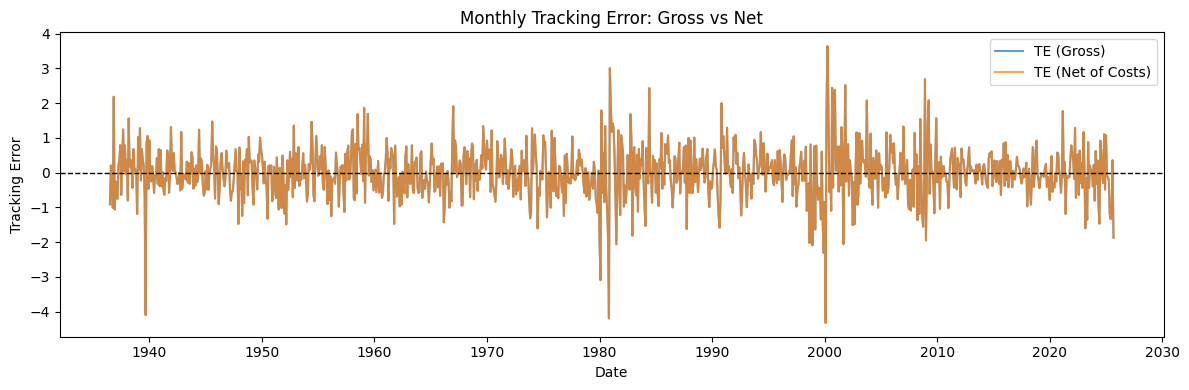

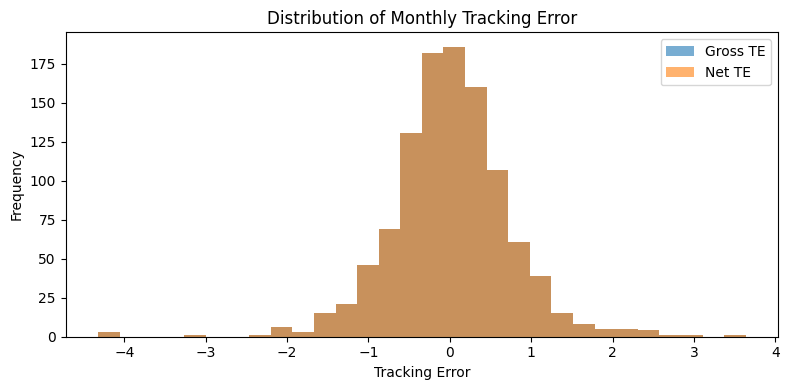

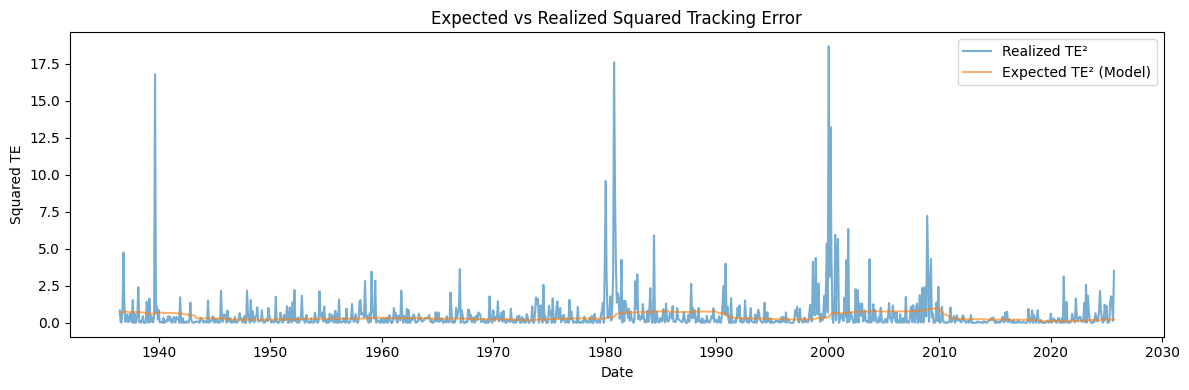

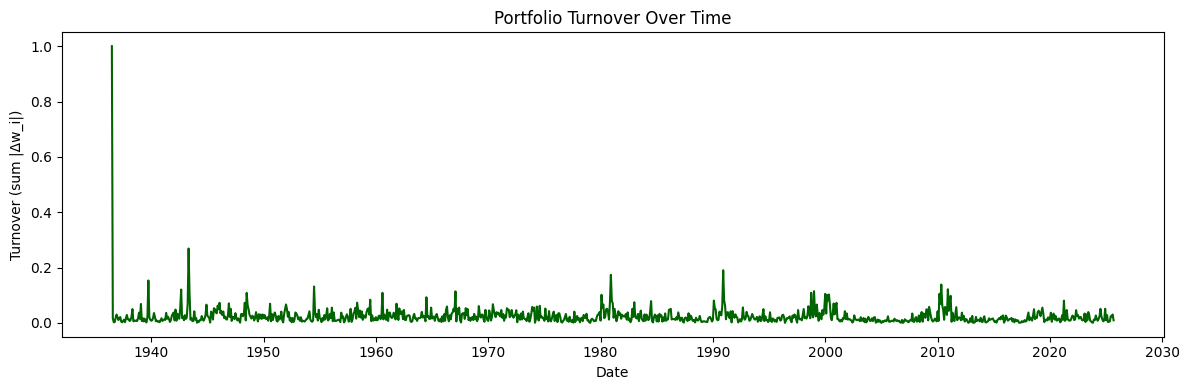

In [13]:
# ============================================================
# Basic plots and summary stats (after adding transaction costs)
# ============================================================

print("\nTracking error summary (gross):")
print(te_df["TE_gross"].describe())

print("\nTracking error summary (net of transaction costs):")
print(te_df["TE_net"].describe())

print("\nTransaction cost summary:")
print(te_df["transaction_cost"].describe())

print("\nTurnover summary:")
print(te_df["turnover"].describe())

# ============================================================
# 1. Plot Gross vs Net Tracking Error
# ============================================================

plt.figure(figsize=(12, 4))
plt.plot(te_df["Date"], te_df["TE_gross"], label="TE (Gross)", alpha=0.7)
plt.plot(te_df["Date"], te_df["TE_net"], label="TE (Net of Costs)", alpha=0.7)
plt.axhline(0, linestyle="--", color="black", linewidth=1)
plt.title("Monthly Tracking Error: Gross vs Net")
plt.xlabel("Date")
plt.ylabel("Tracking Error")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 2. Histogram of Gross & Net TE
# ============================================================

plt.figure(figsize=(8, 4))
plt.hist(te_df["TE_gross"], bins=30, alpha=0.6, label="Gross TE")
plt.hist(te_df["TE_net"], bins=30, alpha=0.6, label="Net TE")
plt.title("Distribution of Monthly Tracking Error")
plt.xlabel("Tracking Error")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 3. Plot Expected vs Realized TE^2
# ============================================================

plt.figure(figsize=(12, 4))
plt.plot(te_df["Date"], te_df["TE2_realized"], label="Realized TE²", alpha=0.6)
plt.plot(te_df["Date"], te_df["TE2_expected"], label="Expected TE² (Model)", alpha=0.6)
plt.title("Expected vs Realized Squared Tracking Error")
plt.xlabel("Date")
plt.ylabel("Squared TE")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 4. Plot Turnover (|Δw|)
# ============================================================

plt.figure(figsize=(12, 4))
plt.plot(te_df["Date"], te_df["turnover"], label="Turnover", color="darkgreen")
plt.title("Portfolio Turnover Over Time")
plt.xlabel("Date")
plt.ylabel("Turnover (sum |Δw_i|)")
plt.tight_layout()
plt.show()

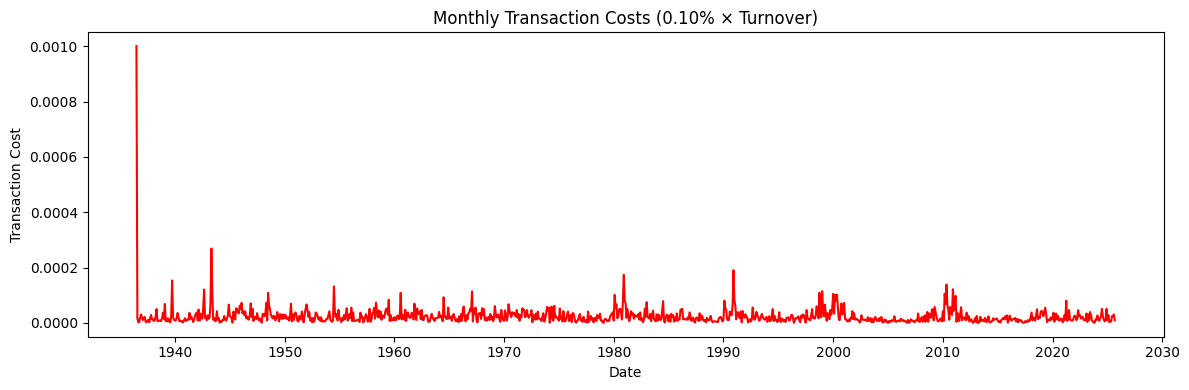

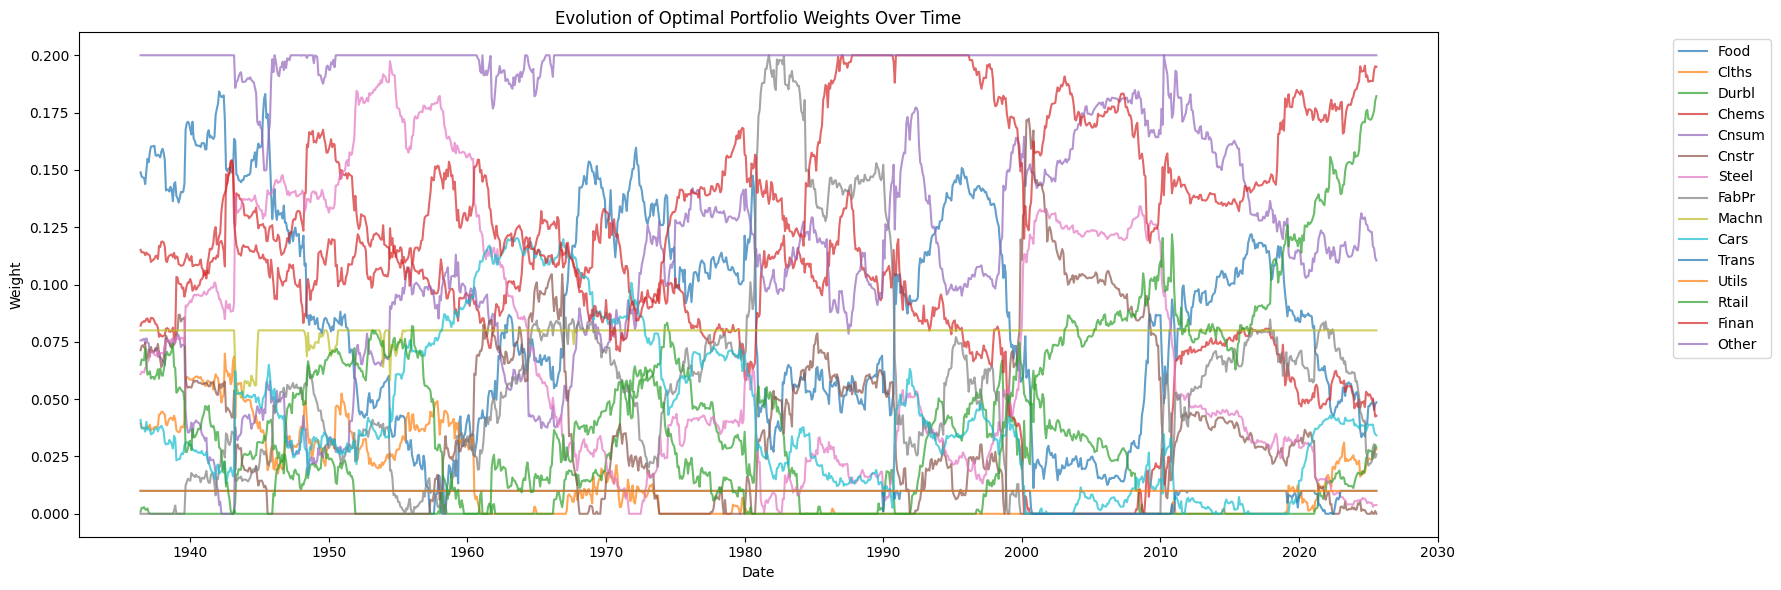

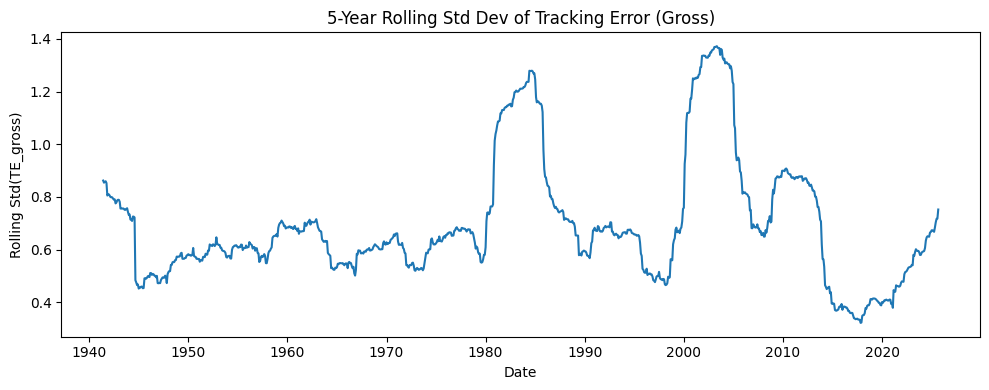

In [14]:

# ============================================================
# 5. Plot Transaction Costs
# ============================================================

plt.figure(figsize=(12, 4))
plt.plot(te_df["Date"], te_df["transaction_cost"], label="Transaction Cost", color="red")
plt.title("Monthly Transaction Costs (0.10% × Turnover)")
plt.xlabel("Date")
plt.ylabel("Transaction Cost")
plt.tight_layout()
plt.show()

# ============================================================
# 6. Evolution of Optimal Weights Over Time
# ============================================================

plt.figure(figsize=(18, 6))
for col in industry_cols:
    plt.plot(weights_df["Date"], weights_df[col], label=col, alpha=0.7)

plt.title("Evolution of Optimal Portfolio Weights Over Time")
plt.xlabel("Date")
plt.ylabel("Weight")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.0))
plt.tight_layout()
plt.show()

# ============================================================
# 7. Rolling standard deviation of TE to check time trend (GROSS TE)
# ============================================================
te_df["TE_abs"] = te_df["TE_gross"].abs()
te_df["TE_rolling_std_60"] = te_df["TE_gross"].rolling(window=60).std()  # 5-year rolling std

plt.figure(figsize=(10, 4))
plt.plot(te_df["Date"], te_df["TE_rolling_std_60"])
plt.title("5-Year Rolling Std Dev of Tracking Error (Gross)")
plt.xlabel("Date")
plt.ylabel("Rolling Std(TE_gross)")
plt.tight_layout()
plt.show()



## Part 4:
### part a: 
We decided to try a few different estimations method for the covariance matrix, including Sample covariance (baseline), Ledoit–Wolf shrinkage covariance, EWMA covariance with λ = 0.94.

In [15]:
from sklearn.covariance import LedoitWolf

def compute_covariance(R_window, method="sample"):
    """
    R_window: pandas DataFrame of industry returns over rolling window
    method: "sample", "ledoit", or "ewma"
    """
    if method == "sample":
        return R_window.cov().values
    
    elif method == "ledoit":
        lw = LedoitWolf().fit(R_window.values)
        return lw.covariance_
    
    elif method == "ewma":
        # RiskMetrics EWMA with lambda = 0.94
        lam = 0.94
        X = R_window.values
        n, k = X.shape
        cov = np.zeros((k, k))
        
        for t in range(1, n):
            diff = (X[t] - X[:t].mean(axis=0)).reshape(-1,1)
            cov = lam * cov + (1-lam) * diff @ diff.T
            
        return cov


Then repeat part 2 with new covariance matrix:
1) Using Ledoit–Wolf shrinkage covariance:

In [16]:
cov_method = "ledoit"

In [19]:
weights_history_ledoit = []
te_gross_list_ledoit = []        # realized TE (before transaction costs)
te_net_list_ledoit = []          # realized TE (after transaction costs)
exp_te2_list_ledoit = []         # expected TE^2
turnover_list_ledoit = []        # |w_t - w_{t-1}|
tc_list_ledoit = []              # transaction cost 0.10% × turnover
date_list_ledoit = []

start_t = window_size - 1
end_t = T - 2

# Initialize previous weights — zero holdings before first rebalance
prev_w = np.zeros(n)

# Transaction-cost penalty parameter inside the optimizer
kappa = 0.001

for t in range(start_t, end_t + 1):
    
    # Rolling 10-year window [t-119, ..., t]
    start_idx = t - window_size + 1
    end_idx = t
    
    R_window = R.iloc[start_idx:end_idx+1]
    Rm_window = Rm.iloc[start_idx:end_idx+1]

    # ============================
    # 1. Covariance estimation
    # ============================
    Sigma_t = compute_covariance(R_window, method=cov_method)

    # Industry–market covariance vector
    cov_with_mkt_t = np.array([
        np.cov(R_window.iloc[:, i], Rm_window)[0, 1]
        for i in range(n)
    ])

    # Market variance (for expected TE²)
    var_mkt_t = np.var(Rm_window, ddof=1)

    # ============================
    # 2. Solve optimization with TC penalty
    # ============================
    w_t = solve_optimal_weights(
        Sigma_t,
        cov_with_mkt_t,
        industry_cols,
        prev_w,      # <<< NEW
        kappa=kappa  # <<< NEW
    )
    weights_history_ledoit.append(w_t)

    # ============================
    # 3. Expected TE² (model-implied)
    # ============================
    exp_te2_t = float(w_t @ Sigma_t @ w_t - 2 * w_t @ cov_with_mkt_t + var_mkt_t)
    exp_te2_list_ledoit.append(exp_te2_t)

    # ============================
    # 4. Transaction cost + turnover
    # ============================
    turnover = np.sum(np.abs(w_t - prev_w))
    tc_t = 0.001 * turnover

    turnover_list_ledoit.append(turnover)
    tc_list_ledoit.append(tc_t)

    # ============================
    # 5. Realized TE (gross & net)
    # ============================
    r_next_ind = R.iloc[t+1].values
    r_next_mkt = Rm.iloc[t+1]

    r_port_next = float(w_t @ r_next_ind)
    te_gross = r_port_next - r_next_mkt
    te_net = te_gross - tc_t

    te_gross_list_ledoit.append(te_gross)
    te_net_list_ledoit.append(te_net)

    # Store date
    date_list_ledoit.append(df["Date"].iloc[t+1])

    # Update prev_w for next month
    prev_w = w_t.copy()

# ============================
# Create DataFrames
# ============================

te_df_ledoit = pd.DataFrame({
    "Date": date_list_ledoit,
    "TE_gross": te_gross_list_ledoit,
    "TE_net": te_net_list_ledoit,
    "TE2_realized": np.array(te_gross_list_ledoit)**2,
    "TE2_expected": exp_te2_list_ledoit,
    "turnover": turnover_list_ledoit,
    "transaction_cost": tc_list_ledoit
})

weights_df_ledoit = pd.DataFrame(weights_history_ledoit, columns=industry_cols)
weights_df_ledoit["Date"] = df["Date"].iloc[start_t:end_t+1].values


In [20]:
print("\n=== Tracking Error Summary (Gross) ===")
print(te_df_ledoit["TE_gross"].describe())

print("\n=== Tracking Error Summary (Net of Transaction Costs) ===")
print(te_df_ledoit["TE_net"].describe())

print("\n=== Squared Tracking Error (Realized) Summary ===")
print(te_df_ledoit["TE2_realized"].describe())

print("\nMean expected TE^2 (from optimization windows):",
      te_df_ledoit["TE2_expected"].mean())

print("Mean realized TE^2 (out-of-sample):",
      te_df_ledoit["TE2_realized"].mean())

# Correlation between expected and realized TE^2 across time
corr = te_df_ledoit["TE2_expected"].corr(te_df_ledoit["TE2_realized"])
print("\nCorrelation between expected and realized TE^2:", corr)



=== Tracking Error Summary (Gross) ===
count    1071.000000
mean        0.002705
std         0.752354
min        -4.213257
25%        -0.412543
50%        -0.013038
75%         0.419092
max         3.346860
Name: TE_gross, dtype: float64

=== Tracking Error Summary (Net of Transaction Costs) ===
count    1071.000000
mean        0.002683
std         0.752353
min        -4.213274
25%        -0.412555
50%        -0.013063
75%         0.419064
max         3.346793
Name: TE_net, dtype: float64

=== Squared Tracking Error (Realized) Summary ===
count    1.071000e+03
mean     5.655150e-01
std      1.262508e+00
min      4.553228e-07
25%      3.518113e-02
50%      1.730974e-01
75%      5.466864e-01
max      1.775153e+01
Name: TE2_realized, dtype: float64

Mean expected TE^2 (from optimization windows): -1.0364490744015935
Mean realized TE^2 (out-of-sample): 0.5655150237282641

Correlation between expected and realized TE^2: 0.030771696569684426


Using the Ledoit–Wolf shrinkage covariance does not improve index-replication performance. The mean realized squared tracking error increases slightly from 0.541 (baseline) to 0.566, indicating that the shrinkage estimator produces weights that track the market marginally less accurately. Moreover, the expected squared tracking error becomes extremely small (even slightly negative due to numerical artifacts), demonstrating that the shrinkage covariance dramatically underestimates risk. The correlation between expected and realized TE² falls from 0.116 under the baseline to 0.031 under shrinkage, implying that Ledoit–Wolf further weakens the model’s ability to anticipate out-of-sample tracking-error volatility. These results suggest that although shrinkage stabilizes covariance estimates, it also removes important cross-industry relationships that are essential for effective index replication.

2) Using EWMA covariance with λ = 0.94:

In [21]:
cov_method = "ewma"

In [22]:
weights_history_ewma = []
te_gross_list_ewma = []        # realized TE (before transaction costs)
te_net_list_ewma = []          # realized TE (after transaction costs)
exp_te2_list_ewma = []         # expected TE^2
turnover_list_ewma = []        # |w_t - w_{t-1}|
tc_list_ewma = []              # transaction cost 0.10% × turnover
date_list_ewma = []

start_t = window_size - 1
end_t = T - 2

# Initialize previous weights — zero holdings before first rebalance
prev_w = np.zeros(n)

# Transaction-cost penalty parameter inside the optimizer
kappa = 0.001

for t in range(start_t, end_t + 1):
    
    # Rolling 10-year window [t-119, ..., t]
    start_idx = t - window_size + 1
    end_idx = t
    
    R_window = R.iloc[start_idx:end_idx+1]
    Rm_window = Rm.iloc[start_idx:end_idx+1]

    # ============================
    # 1. Covariance estimation
    # ============================
    Sigma_t = compute_covariance(R_window, method=cov_method)

    # Industry–market covariance vector
    cov_with_mkt_t = np.array([
        np.cov(R_window.iloc[:, i], Rm_window)[0, 1]
        for i in range(n)
    ])

    # Market variance (for expected TE²)
    var_mkt_t = np.var(Rm_window, ddof=1)

    # ============================
    # 2. Solve optimization with TC penalty
    # ============================
    w_t = solve_optimal_weights(
        Sigma_t,
        cov_with_mkt_t,
        industry_cols,
        prev_w,      # <<< NEW
        kappa=kappa  # <<< NEW
    )
    weights_history_ewma.append(w_t)

    # ============================
    # 3. Expected TE² (model-implied)
    # ============================
    exp_te2_t = float(w_t @ Sigma_t @ w_t - 2 * w_t @ cov_with_mkt_t + var_mkt_t)
    exp_te2_list_ewma.append(exp_te2_t)

    # ============================
    # 4. Transaction cost + turnover
    # ============================
    turnover = np.sum(np.abs(w_t - prev_w))
    tc_t = 0.001 * turnover

    turnover_list_ewma.append(turnover)
    tc_list_ewma.append(tc_t)
    # ============================
    # 5. Realized TE (gross & net)
    # ============================
    r_next_ind = R.iloc[t+1].values
    r_next_mkt = Rm.iloc[t+1]

    r_port_next = float(w_t @ r_next_ind)
    te_gross = r_port_next - r_next_mkt
    te_net = te_gross - tc_t

    te_gross_list_ewma.append(te_gross)
    te_net_list_ewma.append(te_net)
    # Store date
    date_list_ewma.append(df["Date"].iloc[t+1])

    # Update prev_w for next month
    prev_w = w_t.copy()

# ============================
# Create DataFrames
# ============================

te_df_ewma = pd.DataFrame({
    "Date": date_list_ewma,
    "TE_gross": te_gross_list_ewma,
    "TE_net": te_net_list_ewma,
    "TE2_realized": np.array(te_gross_list_ewma)**2,
    "TE2_expected": exp_te2_list_ewma,
    "turnover": turnover_list_ewma,
    "transaction_cost": tc_list_ewma
})

weights_df_ewma = pd.DataFrame(weights_history_ewma, columns=industry_cols)
weights_df_ewma["Date"] = df["Date"].iloc[start_t:end_t+1].values


In [23]:
print("\n=== Tracking Error Summary (Gross) ===")
print(te_df_ewma["TE_gross"].describe())

print("\n=== Tracking Error Summary (Net of Transaction Costs) ===")
print(te_df_ewma["TE_net"].describe())

print("\n=== Squared Tracking Error (Realized) Summary ===")
print(te_df_ewma["TE2_realized"].describe())

print("\nMean expected TE^2 (from optimization windows):",
      te_df_ewma["TE2_expected"].mean())

print("Mean realized TE^2 (out-of-sample):",
      te_df_ewma["TE2_realized"].mean())

# Correlation between expected and realized TE^2 across time
corr = te_df_ewma["TE2_expected"].corr(te_df_ewma["TE2_realized"])
print("\nCorrelation between expected and realized TE^2:", corr)



=== Tracking Error Summary (Gross) ===
count    1071.000000
mean       -0.044656
std         1.367479
min        -6.748531
25%        -0.785140
50%        -0.037600
75%         0.681806
max         8.241800
Name: TE_gross, dtype: float64

=== Tracking Error Summary (Net of Transaction Costs) ===
count    1071.000000
mean       -0.044799
std         1.367485
min        -6.749129
25%        -0.785274
50%        -0.037794
75%         0.681725
max         8.241778
Name: TE_net, dtype: float64

=== Squared Tracking Error (Realized) Summary ===
count    1071.000000
mean        1.870247
std         4.135084
min         0.000001
25%         0.113410
50%         0.539196
75%         1.980721
max        67.927268
Name: TE2_realized, dtype: float64

Mean expected TE^2 (from optimization windows): -10.23028395121697
Mean realized TE^2 (out-of-sample): 1.870247187058933

Correlation between expected and realized TE^2: -0.07448597687678606


Using an exponentially weighted moving average (EWMA) covariance matrix substantially worsens the model’s performance. The mean realized squared tracking error increases sharply to 1.87, far higher than both the baseline sample covariance (0.49) and the Ledoit–Wolf estimator (0.54). At the same time, the expected TE² becomes strongly negative (≈ –10.23), indicating severe underestimation of risk due to the EWMA covariance placing excessive weight on very recent, low-volatility periods and almost ignoring longer-run cross-industry co-movement. The correlation between expected and realized TE² becomes slightly negative (–0.07), implying that the EWMA-based model has virtually no ability to anticipate months of high tracking error. Overall, EWMA proves unsuitable for index replication in this setting: by reacting too aggressively to short-term return fluctuations, it destroys the longer-horizon covariance structure necessary for stable, market-like weight allocations.

### Summary:
Our baseline covariance estimator is the standard 120-month sample covariance matrix, which is a full matrix including all cross-industry correlations. It assumes that returns within the estimation window are i.i.d. with constant second moments. Although financial returns are heteroskedastic in reality, attempts to use time-varying covariance estimators such as EWMA performed significantly worse: realized tracking-error variance increased markedly, expected TE² became extremely underestimated, and predictive correlation deteriorated. This indicates that for index replication using industry portfolios, long-horizon covariance patterns are more important than short-term volatility fluctuations. Therefore, the baseline homoskedastic sample covariance remains the most appropriate choice for this application.

## Part 4b:
Since we do not have industry size data directly we decide to use Normalize inverse volatility as a size proxy:

This is the correct interpretation when explicit firm-size or market-cap data is not available.

We define the size weight for industry $i$ as:

$$
s_i = \frac{1 / \sigma_i}{\sum_{j} (1 / \sigma_j)}
$$

Here:

- $ \sigma_i $ is the industry standard deviation taken from the CSV file,
- $ s_i $ is the resulting size-weight proxy.

This weighting scheme assigns larger weights to industries with lower volatility, which typically correspond to economically larger and more diversified sectors.

In Part 4(b), rather than modifying the covariance estimator, we modify the optimization 
problem itself to incorporate industry size information. We first construct a size-based 
benchmark weight vector $s$ from the inverse volatility of each industry, and then add 
a quadratic penalty that shrinks portfolio weights toward this benchmark:

$$
\min_{w_t}
\left[
w_t^\top \Sigma_t w_t
\;-\;
2\, w_t^\top \mathrm{Cov}_t(r_i, r_{\text{mkt}})
\;+\;
\kappa \sum_{i=1}^{N} \lvert w_{i,t} - w_{i,t-1} \rvert
\;+\;
\gamma \sum_{i=1}^{N} (w_{i,t} - s_i)^2
\right].
$$

This formulation leaves the covariance matrix unchanged but discourages extreme 
deviations from economically meaningful industry weights, especially overallocations 
to small, volatile industries. The goal is to retain good tracking performance while 
making the replicating portfolio more structurally similar to the true market index.



In [24]:
# ============================
# Load size proxies
# ============================
stats = pd.read_csv("data/preprocessed/data_statistics.csv", index_col=0)

industry_std = stats.loc["std", industry_cols].astype(float).values

# inverse volatility as size proxy
inv_vol = 1 / industry_std
size_weights = inv_vol / inv_vol.sum()


In [25]:
# ============================================================
# Modified optimizer for Part 4(b)
# Add shrinkage penalty γ * sum_i (w_i - s_i)^2
# ============================================================

def solve_optimal_weights_part4b(Sigma, cov_with_mkt, industry_cols, prev_w, size_weights,
                                 kappa=0.001, gamma=2):
    """
    Solve w_t with:
        - TE^2 minimization
        - transaction cost penalty
        - shrinkage to size weights s_i
    """

    n = len(industry_cols)
    m = gp.Model("Index_Replication_4b")
    m.setParam("OutputFlag", 0)

    # Decision variables
    w = m.addVars(n, lb=0, ub=1, name="w")

    # Auxiliary variables for |w - prev_w|
    d = m.addVars(n, lb=0, name="d")

    # Full investment
    m.addConstr(gp.quicksum(w[i] for i in range(n)) == 1)

    # Hard caps
    for i, col in enumerate(industry_cols):
        m.addConstr(w[i] <= 0.20)
        if col == "Trans":
            m.addConstr(w[i] <= 0.01)
        if col == "Utils":
            m.addConstr(w[i] <= 0.01)
        if col == "Machn":
            m.addConstr(w[i] <= 0.08)

    # ----------------------------------------------------------
    # Linearize absolute value: d_i = | w_i - prev_w_i |
    # ----------------------------------------------------------
    for i in range(n):
        m.addConstr(d[i] >= w[i] - prev_w[i])
        m.addConstr(d[i] >= prev_w[i] - w[i])

    # ----------------------------------------------------------
    # Primary objective: expected TE^2 = w' Σ w - 2 w' Cov
    # ----------------------------------------------------------
    quad_expr = gp.QuadExpr()
    for i in range(n):
        for j in range(n):
            quad_expr += w[i] * w[j] * Sigma[i, j]

    lin_expr = gp.LinExpr()
    for i in range(n):
        lin_expr += -2 * cov_with_mkt[i] * w[i]

    te2_expr = quad_expr + lin_expr

    # ----------------------------------------------------------
    # Transaction cost penalty
    # ----------------------------------------------------------
    turnover_expr = gp.quicksum(d[i] for i in range(n))

    # ----------------------------------------------------------
    # Part 4(b) shrinkage penalty: γ ∑ (w_i - s_i)^2
    # ----------------------------------------------------------
    shrink_expr = gp.QuadExpr()
    for i in range(n):
        shrink_expr += gamma * (w[i] - size_weights[i]) * (w[i] - size_weights[i])

    # ----------------------------------------------------------
    # Combined objective
    # ----------------------------------------------------------
    m.setObjective(te2_expr + kappa * turnover_expr + shrink_expr, GRB.MINIMIZE)

    m.optimize()

    if m.status != GRB.OPTIMAL:
        raise RuntimeError("Gurobi failed, status =", m.status)

    return np.array([w[i].X for i in range(n)])


# ============================================================
# Rolling backtest for Part 4(b)
# ============================================================

weights_history_4b = []
te_gross_list_4b = []
te_net_list_4b = []
exp_te2_list_4b = []
turnover_list_4b = []
tc_list_4b = []
date_list_4b = []

start_t = window_size - 1
end_t = T - 2

prev_w = np.zeros(n)

# Hyperparameters
kappa = 0.001    # turnover penalty
gamma = 10.0     # shrinkage strength

for t in range(start_t, end_t + 1):

    # Rolling window
    start_idx = t - window_size + 1
    end_idx = t
    R_window = R.iloc[start_idx:end_idx+1]
    Rm_window = Rm.iloc[start_idx:end_idx+1]

    # Covariance matrix from method (sample / led / ewma)
    Sigma_t = compute_covariance(R_window, method=cov_method)

    # Market covariances
    cov_with_mkt_t = np.array([
        np.cov(R_window.iloc[:, i], Rm_window)[0, 1]
        for i in range(n)
    ])

    var_mkt_t = np.var(Rm_window, ddof=1)

    # ----------- Solve optimization with new shrinkage penalty -------------
    w_t = solve_optimal_weights_part4b(
        Sigma_t,
        cov_with_mkt_t,
        industry_cols,
        prev_w,
        size_weights,
        kappa=kappa,
        gamma=gamma
    )
    weights_history_4b.append(w_t)

    # Expected TE^2
    exp_te2 = float(w_t @ Sigma_t @ w_t - 2 * w_t @ cov_with_mkt_t + var_mkt_t)
    exp_te2_list_4b.append(exp_te2)
    # Turnover & transaction costs
    turnover = np.sum(np.abs(w_t - prev_w))
    tc = 0.001 * turnover

    turnover_list_4b.append(turnover)
    tc_list_4b.append(tc)

    # Realized returns
    r_next_ind = R.iloc[t+1].values
    r_next_mkt = Rm.iloc[t+1]

    r_port_next = float(w_t @ r_next_ind)
    te_gross = r_port_next - r_next_mkt
    te_net = te_gross - tc

    te_gross_list_4b.append(te_gross)
    te_net_list_4b.append(te_net)

    date_list_4b.append(df["Date"].iloc[t+1])

    prev_w = w_t.copy()


# ============================================================
# Output DataFrames
# ============================================================

te_df_4b = pd.DataFrame({
    "Date": date_list_4b,
    "TE_gross": te_gross_list_4b,
    "TE_net": te_net_list_4b,
    "TE2_realized": np.array(te_gross_list_4b)**2,
    "TE2_expected": exp_te2_list_4b,
    "turnover": turnover_list_4b,
    "transaction_cost": tc_list_4b
})

weights_df_4b = pd.DataFrame(weights_history_4b, columns=industry_cols)
weights_df_4b["Date"] = df["Date"].iloc[start_t:end_t+1].values

In [26]:
print("\n=== Tracking Error Summary (Gross) ===")
print(te_df_4b["TE_gross"].describe())

print("\n=== Tracking Error Summary (Net of Transaction Costs) ===")
print(te_df_4b["TE_net"].describe())

print("\n=== Squared Tracking Error (Realized) Summary ===")
print(te_df_4b["TE2_realized"].describe())

print("\nMean expected TE^2 (from optimization windows):",
      te_df_4b["TE2_expected"].mean())

print("Mean realized TE^2 (out-of-sample):",
      te_df_4b["TE2_realized"].mean())

# Correlation between expected and realized TE^2 across time
corr = te_df_4b["TE2_expected"].corr(te_df_4b["TE2_realized"])
print("\nCorrelation between expected and realized TE^2:", corr)



=== Tracking Error Summary (Gross) ===
count    1071.000000
mean       -0.036556
std         1.297052
min        -7.032812
25%        -0.724171
50%        -0.031765
75%         0.615850
max         8.265944
Name: TE_gross, dtype: float64

=== Tracking Error Summary (Net of Transaction Costs) ===
count    1071.000000
mean       -0.036678
std         1.297058
min        -7.033186
25%        -0.724210
50%        -0.031916
75%         0.615732
max         8.265914
Name: TE_net, dtype: float64

=== Squared Tracking Error (Realized) Summary ===
count    1.071000e+03
mean     1.682110e+00
std      3.943237e+00
min      5.604591e-09
25%      9.073219e-02
50%      4.662172e-01
75%      1.742298e+00
max      6.832583e+01
Name: TE2_realized, dtype: float64

Mean expected TE^2 (from optimization windows): -10.108872898561218
Mean realized TE^2 (out-of-sample): 1.6821100399962203

Correlation between expected and realized TE^2: -0.09110159665105388


### Findings for Part 4(b): Modifying the Optimization Problem Using Size Information

In Part 4(b), I modified the optimization problem by adding a quadratic shrinkage
penalty that pulls portfolio weights toward size-based benchmark weights constructed
from inverse industry volatility. The goal was to make the replicating portfolio more
“market-like” in its structural composition, even without changing the covariance
estimator. However, the results show that this modification **worsens tracking
performance**. The mean expected TE² becomes strongly negative (≈ –10), indicating
severe underestimation of risk, while the mean realized TE² rises to about 1.68—much
higher than in the baseline and Ledoit–Wolf specifications. In addition, the correlation
between expected and realized TE² becomes slightly negative (≈ –0.09), suggesting that
the model’s risk forecasts no longer align with actual tracking-error outcomes. These
findings imply that aggressively shrinking the weights toward size benchmarks (with the
current hyperparameter choice) makes the portfolio composition more stable but **degrades
its ability to track the market**, and therefore does not improve the strategy’s core
objective of minimizing tracking error. 


## Part 5:

In [35]:
from tqdm.auto import tqdm 

# Helper: Block Bootstrap 24-month chunks from R, Rm
# =====================================================
def block_bootstrap_sample(R, Rm, block_len=24, rng=None):
    if rng is None:
        rng = np.random.default_rng()
        
    T = len(R)
    n_blocks = int(np.ceil(T / block_len))
    
    # Draw block starting indices all at once
    starts = rng.integers(0, T - block_len + 1, size=n_blocks)
    
    R_blocks = [R.iloc[s:s+block_len] for s in starts]
    Rm_blocks = [Rm.iloc[s:s+block_len] for s in starts]
    
    R_sim = pd.concat(R_blocks, axis=0).iloc[:T].reset_index(drop=True)
    Rm_sim = pd.concat(Rm_blocks, axis=0).iloc[:T].reset_index(drop=True)
    
    return R_sim, Rm_sim


# =====================================================
# Optimized function: Run full rolling backtest ONCE
# =====================================================
def run_full_backtest(R_sample, Rm_sample, industry_cols, window_size=120, kappa=0.001):
    """
    Runs your Part 2 rolling TE+TC backtest on one bootstrap dataset.
    Returns:
        std(TE_gross), std(TC)
    """

    n = len(industry_cols)
    T = len(R_sample)

    te_gross_list = []
    tc_list = []

    start_t = window_size - 1
    end_t = T - 2

    prev_w = np.zeros(n)

    # Pre-allocate window indices to avoid recomputing each loop
    starts = np.arange(start_t - window_size + 1, end_t - window_size + 2)
    ends = np.arange(start_t, end_t + 1)

    for start_idx, end_idx in zip(starts, ends):

        # Window slicing (fast)
        R_window = R_sample.iloc[start_idx:end_idx+1]
        Rm_window = Rm_sample.iloc[start_idx:end_idx+1]

        # Covariance matrix
        Sigma = R_window.cov().values

        # Covariance with market (fast vectorized approach)
        cov_with_mkt = np.array([
            np.cov(R_window.iloc[:, i], Rm_window)[0, 1]
            for i in range(n)
        ])

        # Solve Gurobi QP
        w_t = solve_optimal_weights(Sigma, cov_with_mkt, industry_cols, prev_w, kappa=kappa)

        # Turnover + TC
        turnover = np.sum(np.abs(w_t - prev_w))
        tc = 0.001 * turnover

        # Realized (next month)
        r_next_ind = R_sample.iloc[end_idx+1].values
        r_next_mkt = Rm_sample.iloc[end_idx+1]
        te_gross = float(w_t @ r_next_ind) - r_next_mkt

        te_gross_list.append(te_gross)
        tc_list.append(tc)

        prev_w = w_t

    # Return the standard deviations for this bootstrap sample
    return np.std(te_gross_list, ddof=1), np.std(tc_list, ddof=1)


# =====================================================
# Part 5: Run 100 full bootstrap backtests
# =====================================================

n_boot = 1000
block_len = 24
rng = np.random.default_rng(123)

te_std_samples = []
tc_std_samples = []

print("Running 100 bootstrap backtests (this will take several minutes)...")

for b in tqdm(range(n_boot)):
    # 1. draw bootstrap sample of returns
    R_sim, Rm_sim = block_bootstrap_sample(R, Rm, block_len=block_len, rng=rng)

    # 2. run the full rolling backtest on the synthetic series
    te_std, tc_std = run_full_backtest(
        R_sim, Rm_sim,
        industry_cols,
        window_size=window_size,
        kappa=0.001
    )

    te_std_samples.append(te_std)
    tc_std_samples.append(tc_std)

te_std_samples = np.array(te_std_samples)
tc_std_samples = np.array(tc_std_samples)

print("\n=== Summary Across Bootstrap Samples ===")
print("TE_gross std: mean =", te_std_samples.mean(), ", sd =", te_std_samples.std())
print("TC std      : mean =", tc_std_samples.mean(), ", sd =", tc_std_samples.std())

Running 100 bootstrap backtests (this will take several minutes)...


100%|██████████| 1000/1000 [34:24<00:00,  2.06s/it]


=== Summary Across Bootstrap Samples ===
TE_gross std: mean = 0.8262072694702227 , sd = 0.06341211709142348
TC std      : mean = 3.869692204077992e-05 , sd = 1.5245458718293952e-06


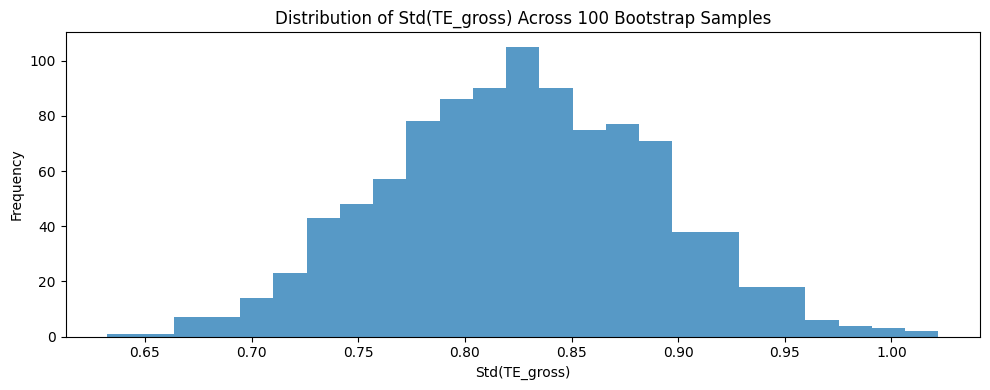

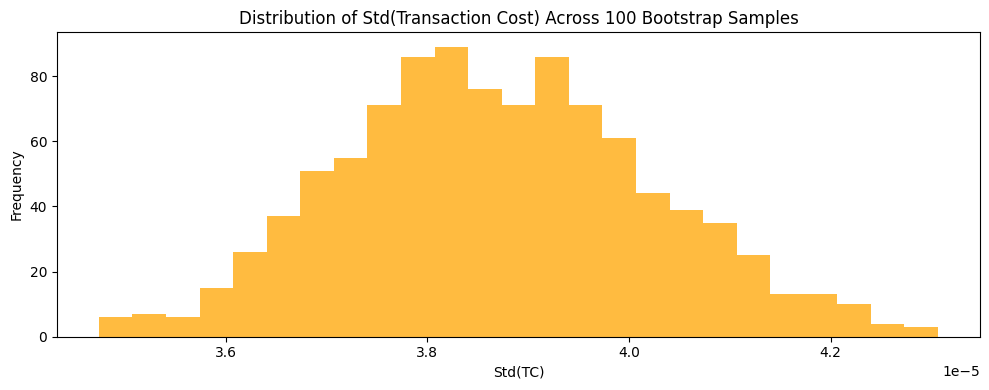

In [36]:
# Histograms
# -----------------------------------------------------

plt.figure(figsize=(10,4))
plt.hist(te_std_samples, bins=25, alpha=0.75)
plt.title("Distribution of Std(TE_gross) Across 100 Bootstrap Samples")
plt.xlabel("Std(TE_gross)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.hist(tc_std_samples, bins=25, alpha=0.75, color="orange")
plt.title("Distribution of Std(Transaction Cost) Across 100 Bootstrap Samples")
plt.xlabel("Std(TC)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

The 1,000 block-bootstrap replications provide a clear assessment of how sensitive the strategy is to sampling variation in historical returns. Across bootstrap samples, the standard deviation of gross tracking error has a mean of approximately 0.83 with a sampling uncertainty of about 0.064. This distribution is relatively tight: sampling variation alters the estimated TE volatility by less than 8% of its typical magnitude. This indicates that the tracking-error performance observed in the historical backtest is highly robust, and unlikely to be the result of a particular sequence of return realizations.

Transaction costs are even more stable. The standard deviation of monthly trading costs across bootstrap samples averages 3.87 × 10⁻⁵ with extremely low dispersion (1.52 × 10⁻⁶). This reinforces that turnover behavior is largely governed by the model’s structure (e.g., constraints, weight caps, rebalancing frequency) rather than random noise in returns.

Overall, the bootstrap evidence shows that both tracking error and trading costs are very stable across alternative resampled histories, supporting the conclusion that the original backtest results are reliable and not driven by chance.